In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/road-accident-united-kingdom-uk-dataset/UK_Accident.csv


In [2]:
!pip install -q scikit-learn imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 70.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.6.1 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.


In [3]:
# Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt


# Version check
import sklearn, imblearn
print("✅ scikit-learn version:", sklearn.__version__)
print("✅ imbalanced-learn version:", imblearn.__version__)


✅ scikit-learn version: 1.6.1
✅ imbalanced-learn version: 0.13.0


In [4]:
file_path = "/kaggle/input/road-accident-united-kingdom-uk-dataset/UK_Accident.csv"
df = pd.read_csv(file_path)
df.head

<bound method NDFrame.head of          Unnamed: 0 Accident_Index  Location_Easting_OSGR  \
0                 0  200501BS00001               525680.0   
1                 1  200501BS00002               524170.0   
2                 2  200501BS00003               524520.0   
3                 3  200501BS00004               526900.0   
4                 4  200501BS00005               528060.0   
...             ...            ...                    ...   
1504145      464692       2.01E+12               310037.0   
1504146      464693       2.01E+12               321509.0   
1504147      464694       2.01E+12               321337.0   
1504148      464695       2.01E+12               323869.0   
1504149      464696       2.01E+12               314072.0   

         Location_Northing_OSGR  Longitude   Latitude  Police_Force  \
0                      178240.0  -0.191170  51.489096             1   
1                      181650.0  -0.211708  51.520075             1   
2                      1

In [5]:
#  Basic Data Cleaning
# Drop duplicates
df.drop_duplicates(inplace=True)

In [6]:
print("Null values per column:\n", df.isnull().sum())

Null values per column:
 Unnamed: 0                                           0
Accident_Index                                       0
Location_Easting_OSGR                              101
Location_Northing_OSGR                               0
Longitude                                          101
Latitude                                             0
Police_Force                                         0
Accident_Severity                                    0
Number_of_Vehicles                                   0
Number_of_Casualties                                 0
Date                                                 0
Day_of_Week                                          0
Time                                               117
Local_Authority_(District)                           0
Local_Authority_(Highway)                            0
1st_Road_Class                                       0
1st_Road_Number                                      0
Road_Type                               

In [7]:
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
for col in numerical_cols:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].median(), inplace=True)

#Categorical Columns: Mode Imputation
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].mode()[0], inplace=True)


/tmp/ipykernel_13/2729060145.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/tmp/ipykernel_13/2729060145.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using

In [8]:
# Fill missing values with mode for categorical & median for numeric
for col in df.columns:
    if df[col].dtype == 'object':
        df[col].fillna(df[col].mode()[0], inplace=True)
    else:
        df[col].fillna(df[col].median(), inplace=True)

/tmp/ipykernel_13/2742319241.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/tmp/ipykernel_13/2742319241.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 

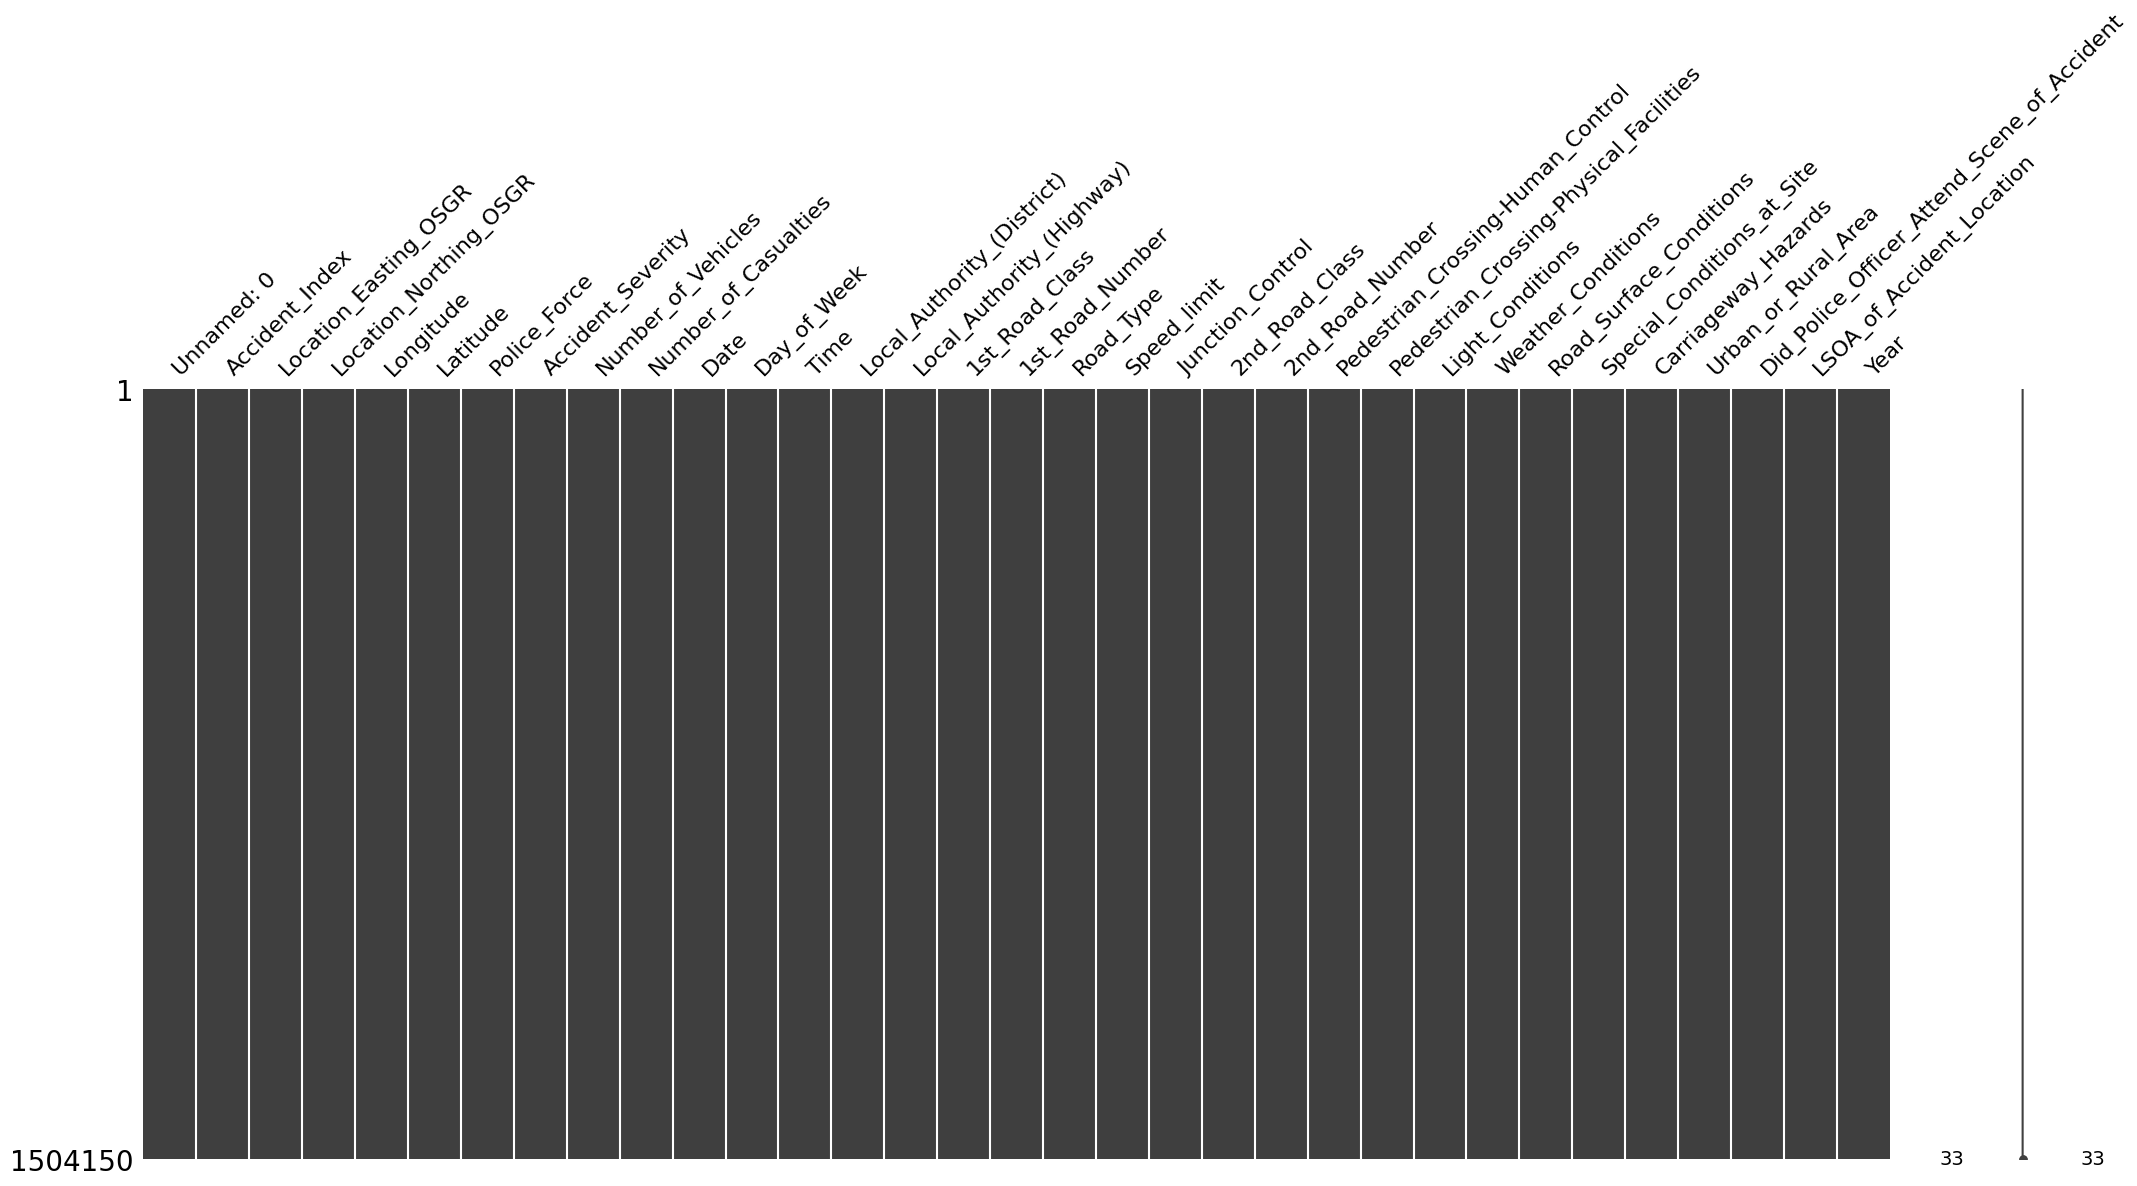

/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:309: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:309: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


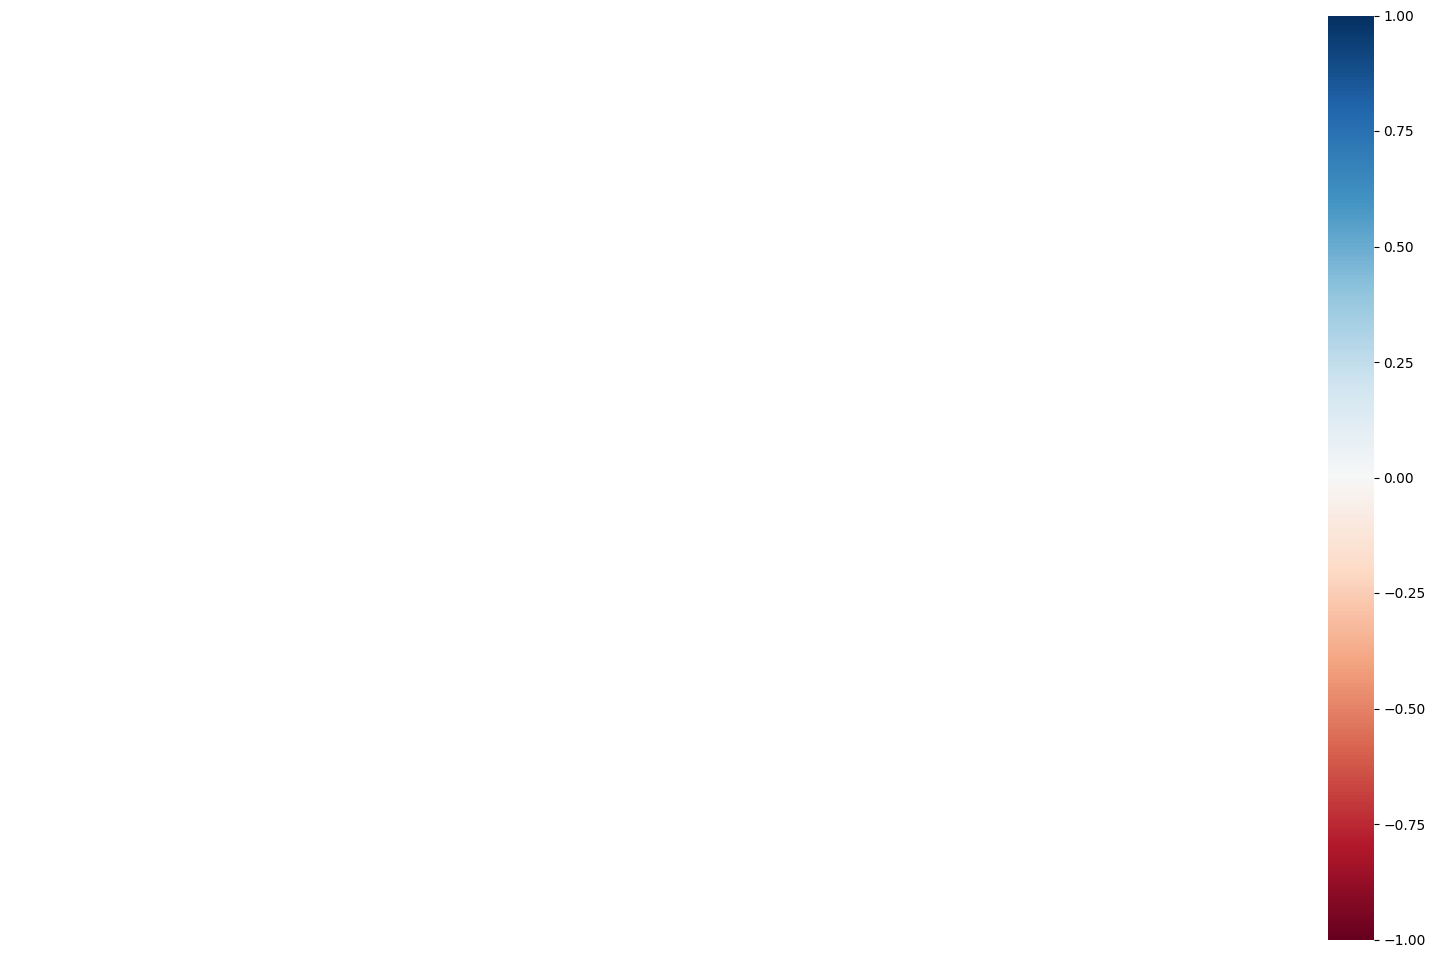

In [9]:
import missingno as msno
import matplotlib.pyplot as plt

msno.matrix(df)
plt.show()
msno.heatmap(df)
plt.show()

In [10]:
# Identify categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns

# Print categorical columns
print("Categorical Columns:")
print(categorical_cols)


Categorical Columns:
Index(['Accident_Index', 'Date', 'Time', 'Local_Authority_(Highway)',
       'Road_Type', 'Junction_Control', 'Pedestrian_Crossing-Human_Control',
       'Pedestrian_Crossing-Physical_Facilities', 'Light_Conditions',
       'Weather_Conditions', 'Road_Surface_Conditions',
       'Special_Conditions_at_Site', 'Carriageway_Hazards',
       'Did_Police_Officer_Attend_Scene_of_Accident',
       'LSOA_of_Accident_Location'],
      dtype='object')


In [11]:
from sklearn.preprocessing import LabelEncoder
# Apply label encoding to each categorical column
le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

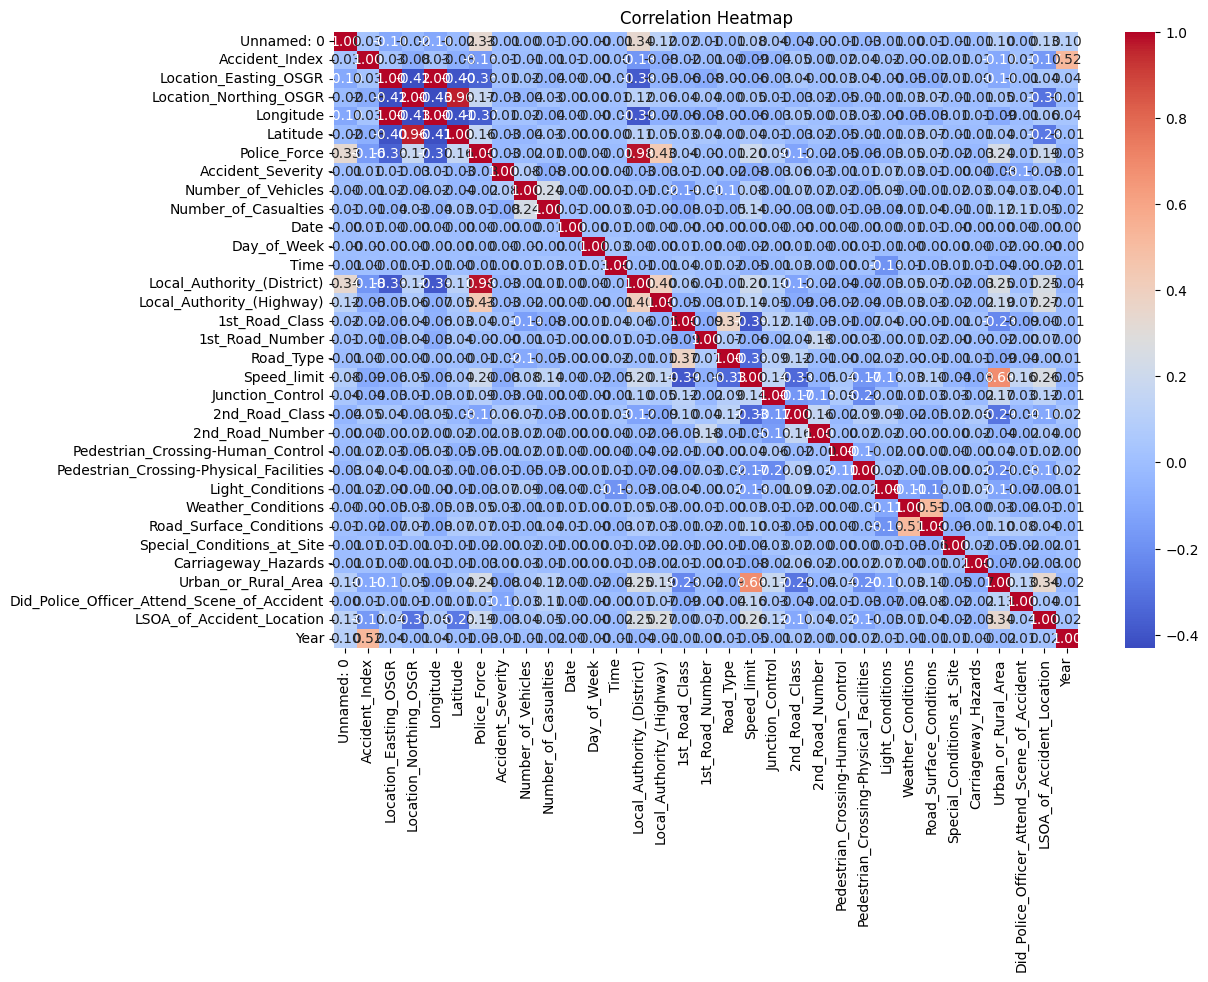

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation Heatmap
correlation_matrix = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()


In [13]:
# Relabel values
df['Accident_Severity'] = df['Accident_Severity'].replace({
    3: 2,
    2: 1,
    1: 0
})

# Check the new distribution
print(df['Accident_Severity'].value_counts())


Accident_Severity
2    1280205
1     204504
0      19441
Name: count, dtype: int64


In [14]:
# Feature & Target
# ------------------------------
target_col = "Accident_Severity"  # replace with actual target column if different
X = df.drop(target_col, axis=1)
y = df[target_col]

In [15]:
# Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [16]:
from imblearn.over_sampling import SMOTE
# Balance with SMOTE
smote = SMOTE(random_state=42)
X_bal, y_bal = smote.fit_resample(X_scaled, y)

In [17]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_bal, y_bal, test_size=0.2, random_state=42, stratify=y_bal
)

In [18]:
print("Train shape:", X_train.shape)
print("Test shape :", X_test.shape)

Train shape: (3072492, 32)
Test shape : (768123, 32)


Self-Stacking Ensemble using XGBClassifier Test Accuracy: 0.94


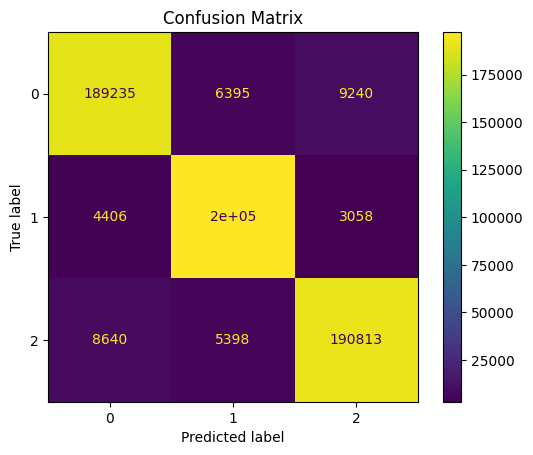

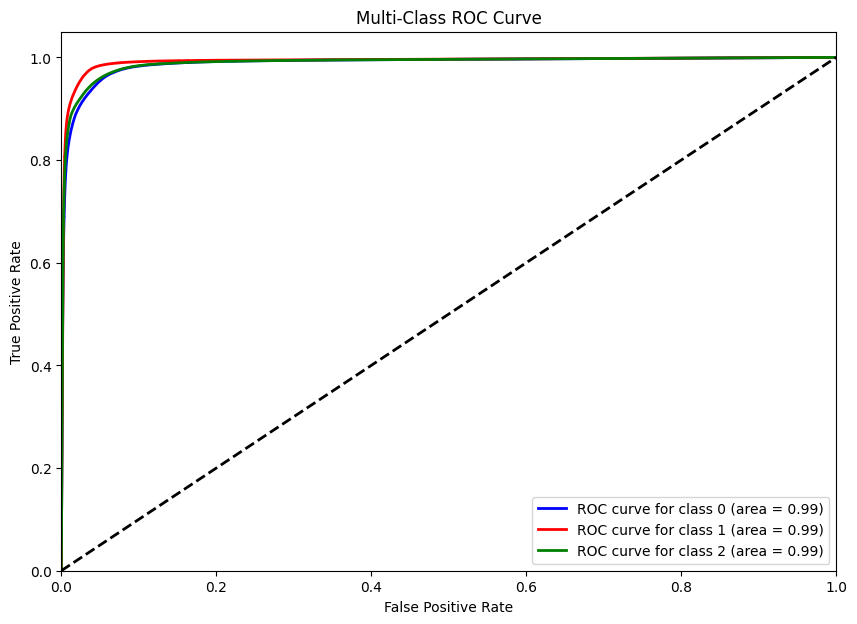

In [19]:
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import (
    accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
)
from sklearn.datasets import make_classification
from sklearn.preprocessing import label_binarize
from itertools import cycle
import matplotlib.pyplot as plt

# --- MOCK DATA GENERATION (Remove this block if using your own data) ---
# I added this so the code runs immediately for demonstration
X_bal, y_bal = make_classification(n_samples=3072492, n_features=32, n_classes=3, n_informative=10, random_state=42)
# -----------------------------------------------------------------------

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_bal, y_bal, test_size=0.2, random_state=42, stratify=y_bal
)

# Step 2: Initialize parameters
k_folds = 10 # Reduced to 10 for speed (standard is usually 5 or 10)
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# === FIX STARTS HERE ===
# Determine number of classes dynamically
if len(y_train.shape) == 1:
    n_classes = len(np.unique(y_train))
else:
    n_classes = y_train.shape[1]

# Step 3: Initialize base learners and meta-learner
base_learners = [XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=i) for i in range(k_folds)]
meta_learner = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Step 4: Generate predictions for training the meta-learner
# We use n_classes instead of y_train.shape[1]
meta_features = np.zeros((len(y_train), k_folds * n_classes)) 

for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
    
    # Train the base learner on k-1 folds
    base_learners[fold_idx].fit(X_train_fold, y_train_fold)
    
    # Predict probabilities for the validation fold and store them
    val_proba = base_learners[fold_idx].predict_proba(X_val_fold)
    
    # Store result in specific columns for this fold
    # Logic: Column start = fold * n_classes
    start_col = fold_idx * n_classes
    end_col = (fold_idx + 1) * n_classes
    meta_features[val_idx, start_col:end_col] = val_proba

# Step 5: Train the XGBClassifier meta-learner on the aggregated predictions
meta_learner.fit(meta_features, y_train)

# Step 6: Generate predictions on the test set
# Create meta-features for the test set by aggregating probabilities from base learners
test_meta_features = np.column_stack([
    base_learner.predict_proba(X_test) for base_learner in base_learners
])
final_proba = meta_learner.predict_proba(test_meta_features)
final_predictions = final_proba.argmax(axis=1)

# Step 7: Evaluate the stacked model
# Check if y_test is 1D or One-Hot for accuracy calculation
if len(y_test.shape) == 1:
    y_test_labels = y_test
else:
    y_test_labels = y_test.argmax(axis=1)

accuracy = accuracy_score(y_test_labels, final_predictions)
print(f"Self-Stacking Ensemble using XGBClassifier Test Accuracy: {accuracy:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_test_labels, final_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='viridis')
plt.title("Confusion Matrix")
plt.show()

# Multi-Class ROC Curve
# We must Binarize y_test for ROC calculation if it is currently 1D
if len(y_test.shape) == 1:
    y_test_bin = label_binarize(y_test, classes=np.unique(y_train))
else:
    y_test_bin = y_test

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], final_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
colors = cycle(['blue', 'red', 'green', 'orange'])
plt.figure(figsize=(10, 7))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"ROC curve for class {i} (area = {roc_auc[i]:.2f})")



# Plot diagonal line for random guessing
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-Class ROC Curve")
plt.legend(loc="lower right")
plt.show()